In [4]:
import functools

import matplotlib
from matplotlib import pyplot
import numpy as np

import sys
sys.path.append("..")
from hiora_cartpole import features
from hiora_cartpole import fourier_fa
from hiora_cartpole import easytile_fa
from hiora_cartpole import offswitch_hfa
from hiora_cartpole import linfa
from hiora_cartpole import driver

import gym_ext.tools as gym_tools

import gym
import gym.wrappers

/home/erle/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
cartpole = gym.make('OffSwitchCartpole-v0')
clipped_high = np.array([2.5, 3.6, 0.27, 3.7])
clipped_low  = -clipped_high
state_ranges = np.array([clipped_low, clipped_high])

[2016-09-26 11:16:04,154] Making new env: OffSwitchCartpole-v0


In [6]:
env = gym.wrappers.TraceRecordingWrapper(cartpole, "/tmp/cartpole-recordings")

In [7]:
four_n_weights, four_feature_vec \
    = fourier_fa.make_feature_vec(state_ranges,
                                  n_acts=2,
                                  order=3)

ofour_n_weights, ofour_feature_vec \
    = offswitch_hfa.make_feature_vec(four_feature_vec, four_n_weights)

    
skip_offswitch_clip = functools.partial(
                          gym_tools.apply_to_snd, 
                          functools.partial(gym_tools.warning_clip_obs, ranges=state_ranges))    

def init_experience():
    return linfa.init(lmbda=0.9,
                        init_alpha=0.001,
                        epsi=0.1,
                        feature_vec=ofour_feature_vec,
                        n_weights=ofour_n_weights,
                        act_space=env.action_space,
                        theta=None,
                        is_use_alpha_bounds=True,
                        map_obs=skip_offswitch_clip)

fexperience = init_experience()

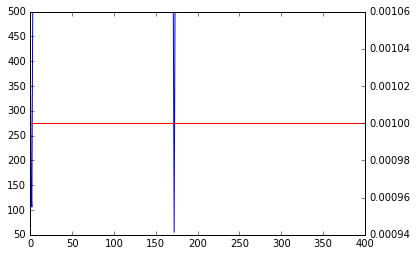

In [30]:
fexperience, steps_per_episode, alpha_per_episode \
    = driver.train(env, linfa, fexperience, n_episodes=400, max_steps=500, is_render=False)
# Credits: http://matplotlib.org/examples/api/two_scales.html
fig, ax1 = pyplot.subplots()
ax1.plot(steps_per_episode, color='b')
ax2 = ax1.twinx()
ax2.plot(alpha_per_episode, color='r')
pyplot.show()

In [39]:
steps_per_episode = driver.exec_greedy(env, fexperience, n_episodes=7, max_steps=600, is_render=True)

In [22]:
env.num_crosses

[0.0, 4.0]

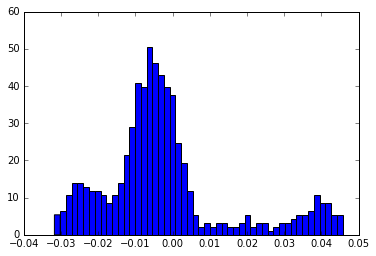

In [41]:
positions = np.array([o[1][0] for o in env.observations])
pyplot.hist(positions, bins=50, normed=True)
pyplot.show()

In [35]:
left_poss = positions[np.and(-1.0 <= positions, positions < 0)]

SyntaxError: invalid syntax (<ipython-input-35-c34e8a26732a>, line 1)

In [42]:
np.histogram(positions, [-1.0, 0.0, 1.0])

(array([428, 173]), array([-1.,  0.,  1.]))

In [24]:
import shutil
import tempfile

def rewards_lefts_rights(n_trainings, n_episodes, max_steps):
    tmpdir = tempfile.mkdtemp(prefix="cartpole-", dir="/tmp")
    print tmpdir
    record_env = gym.wrappers.TraceRecordingWrapper(
                     gym.make("OffSwitchCartpole-v0"), tmpdir)
    record_env.buffer_batch_size = max_steps * n_episodes
    
    rewards_per_episode = []
    lefts_rights = np.zeros((2,), dtype=np.int)

    for i_training in xrange(n_trainings):
        driver.train(record_env, linfa, init_experience(),
                     n_episodes=n_episodes, max_steps=max_steps)
        rewards_per_episode += [np.sum(e['rewards']) for e in record_env.episodes]
        poss = np.array([o[1][0] for e in record_env.episodes
                                 for o in e['observations']])
        lefts_rights += np.histogram(poss, [-1.0, 0.0, 1.0])[0]

        record_env.episodes            = []
        record_env.episodes_first      = None
        record_env.buffered_step_count = 0
        
    shutil.rmtree(tmpdir)
        
    return rewards_per_episode, lefts_rights    

In [21]:
tempfile.mkdtemp(prefix="cartpole-", dir="/tmp")

'/tmp/cartpole-3AT3Cf'

In [38]:
import multiprocessing
n_procs     = 4
pool = multiprocessing.Pool(n_procs)
n_trainings = 16
n_episodes  = 200
max_steps   = 500
args = [n_trainings // n_procs, n_episodes, max_steps]

results = [pool.apply_async(rewards_lefts_rights, args)
               for _ in xrange(n_procs)]
answers = [r.get() for r in results]
rewards_per_episode = [r for a in answers for r in a[0]]
lefts_rights = np.sum(np.array([a[1] for a in answers]), axis=0)

/tmp/cartpole-yrr_2A
/tmp/cartpole-Nd8nif
/tmp/cartpole-VQEfK7
/tmp/cartpole-dLecuD


[2016-09-26 12:21:58,455] Making new env: OffSwitchCartpole-v0
[2016-09-26 12:21:58,458] Making new env: OffSwitchCartpole-v0
[2016-09-26 12:21:58,457] Making new env: OffSwitchCartpole-v0
[2016-09-26 12:21:58,461] Making new env: OffSwitchCartpole-v0
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored
Exception IOError: IOError(2, 'No such file or directory') in <bound method TraceRecordingWrapper.__del__ of <TraceRecordingWrapper<OffSwitchCartpoleEnv instance>>> ignored


[568730 763095]


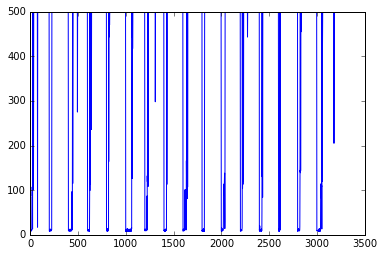

In [39]:
print lefts_rights
pyplot.plot(rewards_per_episode)
pyplot.show()

In [51]:

np.histogram(positions, [-1.0, 0.0, 1.0])

(array([ 5100, 15942]), array([-1.,  0.,  1.]))